In [551]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from PIL import Image, ImageOps
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [552]:
import os
from PIL import Image, UnidentifiedImageError

# Root directory of the images
root_dir = 'trafficsigns_dataset'  # Replace with the actual path

# Nested dictionary to store images categorized by two levels of labels
images_by_label = {}

# Function to traverse the dataset and load images and their labels
def load_images_and_labels(root_dir):
    # Iterate through each subdirectory in the root directory (first level)
    for sub_dir in os.listdir(root_dir):
        sub_dir_path = os.path.join(root_dir, sub_dir)
        
        # Check if the subdirectory is indeed a directory
        if os.path.isdir(sub_dir_path):
            # Initialize the first level label key
            images_by_label[sub_dir] = {}
            
            # Iterate again through the folders within the subdirectory (second level, specific labels)
            for label_dir in os.listdir(sub_dir_path):
                label_dir_path = os.path.join(sub_dir_path, label_dir)
                
                # Check if the second level is also a directory
                if os.path.isdir(label_dir_path):
                    # Initialize the second level label key
                    images_by_label[sub_dir][label_dir] = []
                    
                    # Iterate through all image files in the second level directory
                    for image_filename in os.listdir(label_dir_path):
                        # Ignore .DS_Store files
                        if image_filename == '.DS_Store':
                            continue
                        image_path = os.path.join(label_dir_path, image_filename)
                        try:
                            images_by_label[sub_dir][label_dir].append(image_path)
                        except UnidentifiedImageError:
                            # Print error message if the image cannot be identified
                            print(f"Cannot identify image file '{image_path}'")

# Load images and labels
load_images_and_labels(root_dir)

# Print the number of images for each category
for sub_dir, labels in images_by_label.items():
    for label, images in labels.items():
        print(f"{sub_dir}/{label}: {len(images)} images")
        
label_names = []
for sub_dir in images_by_label:
    for label in images_by_label[sub_dir]:
        if label not in label_names:
            label_names.append(label)

# Sort label names to maintain consistency
label_names.sort()

# Now label_names contains all unique labels, sorted alphabetically


diamond/rightofway: 282 images
hex/stop: 43 images
square/laneend: 118 images
square/parking: 276 images
square/continue: 199 images
square/crossing: 95 images
triangle/giveway: 231 images
triangle/warning: 695 images
round/traveldirection: 124 images
round/limitedtraffic: 125 images
round/speed: 316 images
round/roundabout: 98 images
round/noentry: 375 images
round/noparking: 242 images
round/bicycle: 285 images
round/trafficdirective: 195 images


28no Unusual

In [553]:
def get_image_sizes(root_dir):
    sizes = []
    # Traverse through the directory structure in root_dir
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file is a PNG or JPG
            if file.lower().endswith('.png') or file.lower().endswith('.jpg'):
                try:
                    # Open the image file and append its size (width, height)
                    with Image.open(os.path.join(subdir, file)) as img:
                        sizes.append(img.size)
                except (IOError, UnidentifiedImageError):
                    # Continue to the next file if an error occurs
                    continue
    return sizes

# Call the function to get the sizes of all images in the directory
image_sizes = get_image_sizes(root_dir)

# Convert list of sizes to a NumPy array for statistical calculation
sizes_np = np.array(image_sizes)
min_size = sizes_np.min(axis=0)
max_size = sizes_np.max(axis=0)
mean_size = sizes_np.mean(axis=0)
std_dev_size = sizes_np.std(axis=0)
median_size = np.median(sizes_np, axis=0)

# Output the minimum, maximum, mean, standard deviation, and median sizes of the images
min_size, max_size, mean_size, std_dev_size, median_size


(array([28, 28]),
 array([28, 28]),
 array([28., 28.]),
 array([0., 0.]),
 array([28., 28.]))

In [554]:
train_data = {}
test_data = {}
validation_data = {}

for first_level, second_level_dict in images_by_label.items():
    train_data[first_level] = {}
    validation_data[first_level] = {}
    test_data[first_level] = {}
    
    for label, image_paths in second_level_dict.items():
        temp_images, test_images = train_test_split(image_paths, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(temp_images, test_size=0.2, random_state=42)
        
        # Save split data
        train_data[first_level][label] = train_images
        test_data[first_level][label] = test_images
        validation_data[first_level][label] = val_images


In [555]:
def create_dataframe_for_16_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                rows.append({'ImagePath': path, 'Label': label})
    return pd.DataFrame(rows)

def create_dataframe_for_5_class(data_dict):
    rows = []
    for first_level, second_level_dict in data_dict.items():
        for label, image_paths in second_level_dict.items():
            for path in image_paths:
                rows.append({'ImagePath': path, 'Label': first_level})
    return pd.DataFrame(rows)

train_df = create_dataframe_for_16_class(train_data)
test_df = create_dataframe_for_16_class(test_data)
validation_df = create_dataframe_for_16_class(validation_data)

In [556]:
batch_size = 64

In [557]:
# Initialize image data generators with rescaling
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a training data generator from a dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=True                # Shuffle the order of the images
)

# Create a validation data generator from a dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)

# Create a test data generator from a dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',          # Column in dataframe that contains the image paths
    y_col='Label',              # Column in dataframe that contains the labels
    color_mode='grayscale',     # Use grayscale images
    target_size=(28, 28),       # Resize images to 28x28 pixels
    batch_size=batch_size,      # Number of images to process in a batch
    class_mode='categorical',   # If it's a multi-class problem
    shuffle=False               # Do not shuffle the images
)


Found 2358 validated image filenames belonging to 16 classes.
Found 596 validated image filenames belonging to 16 classes.
Found 745 validated image filenames belonging to 16 classes.


## Transfer data to suit scikit-learn

In [558]:
import numpy as np

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure not to iterate infinitely
    return np.vstack(batches), np.vstack(labels)

# Get training, validation, and test data and labels
X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)


## Decision Tree

In [559]:
# Assume the original shape of X_train and X_val is [number of samples, 28, 28, 1] - as extracted from an image generator

# Reshape X_train and X_val into two-dimensional arrays, one row per image
X_train = X_train.reshape(X_train.shape[0], -1)  # -1 calculates the necessary size based on the remaining dimensions
X_val = X_val.reshape(X_val.shape[0], -1)

# If using get_data_from_generator function to extract data, make sure to adjust the function or data before reshaping
# For example, ensure data is correctly extracted and transformed from the generator
X_train, y_train = get_data_from_generator(train_generator)
X_train = X_train.reshape(X_train.shape[0], -1)

X_val, y_val = get_data_from_generator(val_generator)
X_val = X_val.reshape(X_val.shape[0], -1)

# Train the decision tree model
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = tree_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.7600671140939598


## Random Forest

In [560]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model using the validation set
y_pred_val = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.7634228187919463


## SVM

In [561]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of categories)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.9379194630872483


## MLP Baseline Model for Multi-class Task


In [562]:
num_classes = 16
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [563]:
baseline_categorical.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [564]:
epochs = 50
history_baseline_categorical = baseline_categorical.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50


/Users/tianbai/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4155 - loss: 2.0993 - val_accuracy: 0.7131 - val_loss: 1.0417
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7673 - loss: 0.9360 - val_accuracy: 0.8456 - val_loss: 0.6665
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8679 - loss: 0.5959 - val_accuracy: 0.8809 - val_loss: 0.5438
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8903 - loss: 0.4874 - val_accuracy: 0.9027 - val_loss: 0.4514
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9028 - loss: 0.3921 - val_accuracy: 0.9362 - val_loss: 0.3552
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9266 - loss: 0.3365 - val_accuracy: 0.9547 - val_loss: 0.3237
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9517 - loss: 0.2818 - val_accuracy: 0.9497 - val_loss: 0.2894
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9419 - loss: 0.2739 - val_accuracy: 0.9178 - val_loss: 0.

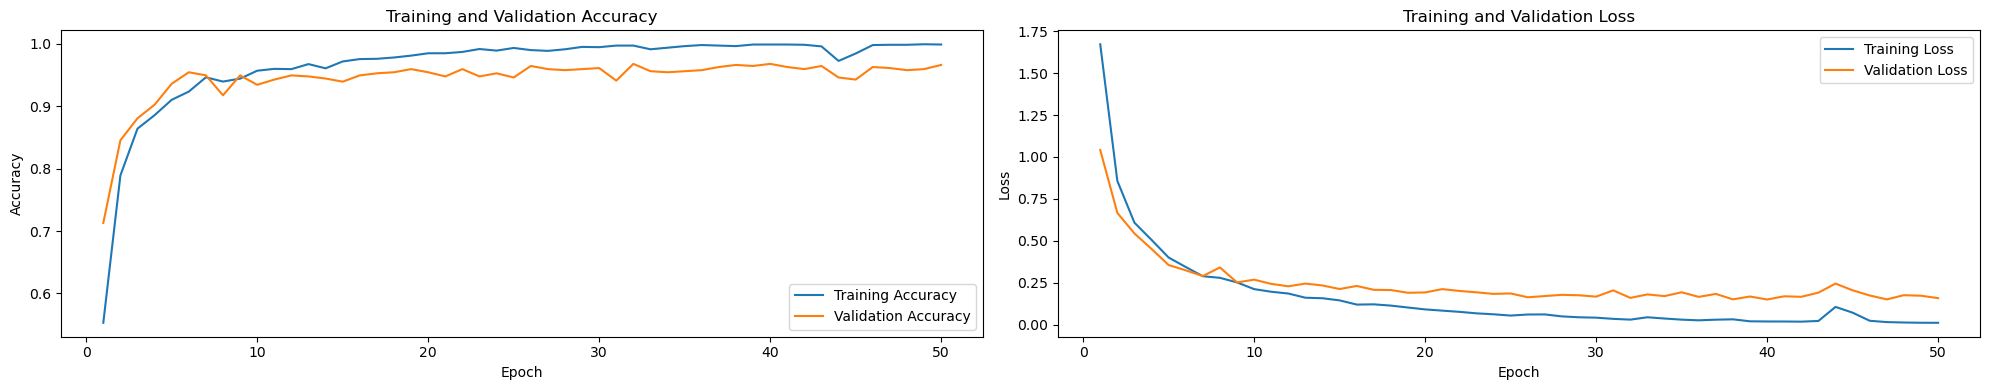

In [565]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation metrics based on the History object from a Keras model.

    Parameters:
    - history: History object returned from the fit method.
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1)  # Assuming there's at least the 'accuracy' metric
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  # Retrieve all non-validation metrics
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  # Dynamically adjust the number of subplots based on the number of metrics

    for idx, metric in enumerate(metrics):
        # Plot the training and validation curve for each metric in each subplot
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

# Assuming history_baseline_categorical is the training history object of your MLP model
# Call the function to plot
plot_training_history(history_baseline_categorical)



## Modify images to make classify more difficult

In [566]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotation range (degrees), adjustable range, e.g., 20-40
    width_shift_range=0.1,  # Horizontal shift range
    height_shift_range=0.1,  # Vertical shift range
    shear_range=0.1,  # Shearing range
    zoom_range=0.1,  # Zoom range
    horizontal_flip=True,  # Horizontal flip
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='ImagePath',
    y_col='Label',
    color_mode='grayscale',
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False
)


Found 2358 validated image filenames belonging to 16 classes.
Found 596 validated image filenames belonging to 16 classes.
Found 745 validated image filenames belonging to 16 classes.


## SVM Model with modified dataset

In [567]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def get_data_from_generator(generator):
    batches = []
    labels = []
    # Iterate over the generator to collect data and labels
    for batch, label in generator:
        batches.append(batch)
        labels.append(label)
        if len(batches) >= len(generator):
            break  # Ensure there is no infinite iteration
    return np.vstack(batches), np.vstack(labels)

X_train, y_train = get_data_from_generator(train_generator)
X_val, y_val = get_data_from_generator(val_generator)
X_test, y_test = get_data_from_generator(test_generator)

# Reshape the data to fit the input requirements of StandardScaler
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Assuming y_train and y_val are one-hot encoded, with shape (number of samples, number of classes)
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

# Initialize and apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='auto', max_iter=1000)

# Train the SVM model
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model on the validation set
y_pred_val = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))


Validation Accuracy: 0.709731543624161


                  precision    recall  f1-score   support

         bicycle       0.69      0.74      0.72        46
        continue       0.79      0.84      0.82        32
        crossing       1.00      0.00      0.00        16
         giveway       0.83      0.78      0.81        37
         laneend       1.00      0.58      0.73        19
  limitedtraffic       0.58      0.35      0.44        20
         noentry       0.82      0.92      0.87        60
       noparking       0.48      0.72      0.58        39
         parking       0.88      0.80      0.83        44
      rightofway       0.83      0.78      0.80        45
      roundabout       1.00      0.12      0.22        16
           speed       0.54      0.71      0.61        51
            stop       1.00      0.00      0.00         7
trafficdirective       0.52      0.41      0.46        32
 traveldirection       1.00      0.20      0.33        20
         warning       0.71      0.96      0.82       112

        accu

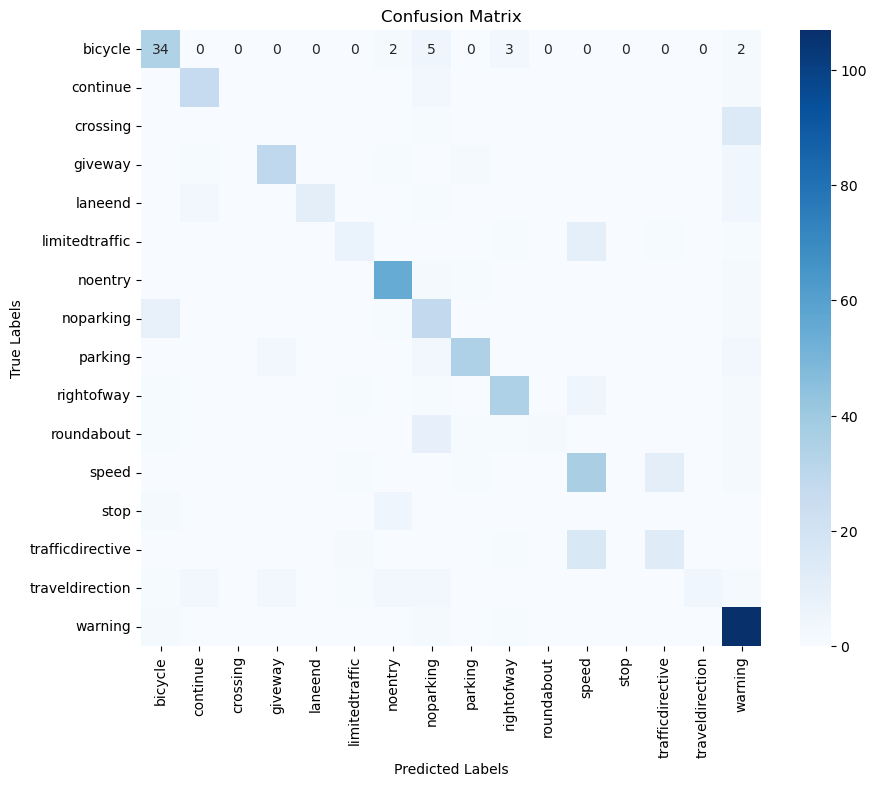

In [568]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(y_val, y_pred_val, target_names=label_names, zero_division=1)
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## MLP Model with modified dataset

In [569]:
num_classes = 16
input_shape = (28, 28)
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [570]:
baseline_categorical.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [571]:
epochs = 50
history_baseline_categorical = baseline_categorical.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/50


/Users/tianbai/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.1658 - loss: 0.3204 - val_accuracy: 0.3054 - val_loss: 0.2127
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2772 - loss: 0.2189 - val_accuracy: 0.4564 - val_loss: 0.1857
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3577 - loss: 0.2031 - val_accuracy: 0.5050 - val_loss: 0.1692
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4140 - loss: 0.1923 - val_accuracy: 0.5839 - val_loss: 0.1577
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4358 - loss: 0.1859 - val_accuracy: 0.5805 - val_loss: 0.1497
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4457 - loss: 0.1780 - val_accuracy: 0.6158 - val_loss: 0.1461
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4677 - loss: 0.1746 - val_accuracy: 0.6409 - val_loss: 0.1396
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4718 - loss: 0.1699 - val_accuracy: 0.6577 - val_loss: 0.

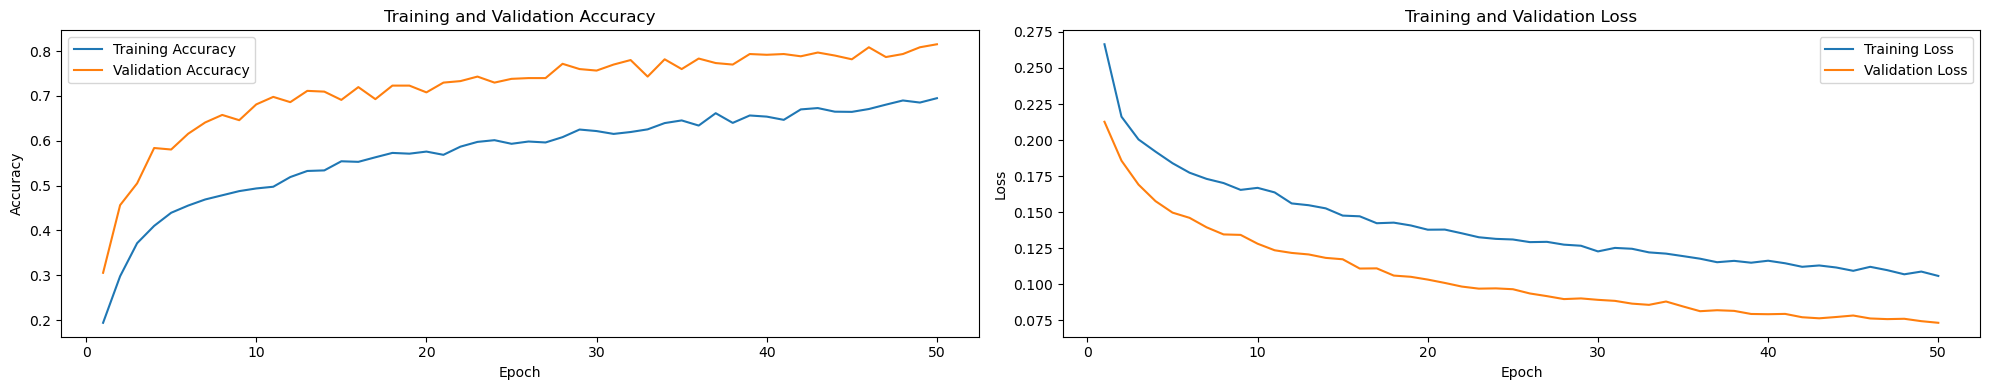

In [572]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    根据Keras模型的History对象绘制训练和验证的指标。

    参数:
    - history: 从fit方法返回的History对象。
    """
    epochs_range = range(1, len(history.history['accuracy']) + 1) 
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  

    for idx, metric in enumerate(metrics):
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_baseline_categorical)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                  precision    recall  f1-score   support

         bicycle       0.85      0.85      0.85        46
        continue       0.86      1.00      0.93        32
        crossing       0.75      0.75      0.75        16
         giveway       0.94      0.89      0.92        37
         laneend       0.84      0.84      0.84        19
  limitedtraffic       0.67      0.70      0.68        20
         noentry       0.81      0.95      0.88        60
       noparking       0.81      0.77      0.79        39
         parking       0.89      0.93      0.91        44
      rightofway       0.82      0.82      0.82        45
      roundabout       0.67      0.75      0.71        16
           speed       0.67      0.80      0.73        51
            stop       1.00      0.14      0.25         7
trafficdirective       0.83      0.47      0.60        32
 traveldirection       0.83      0.25      0.38        20
         warning       0.84    

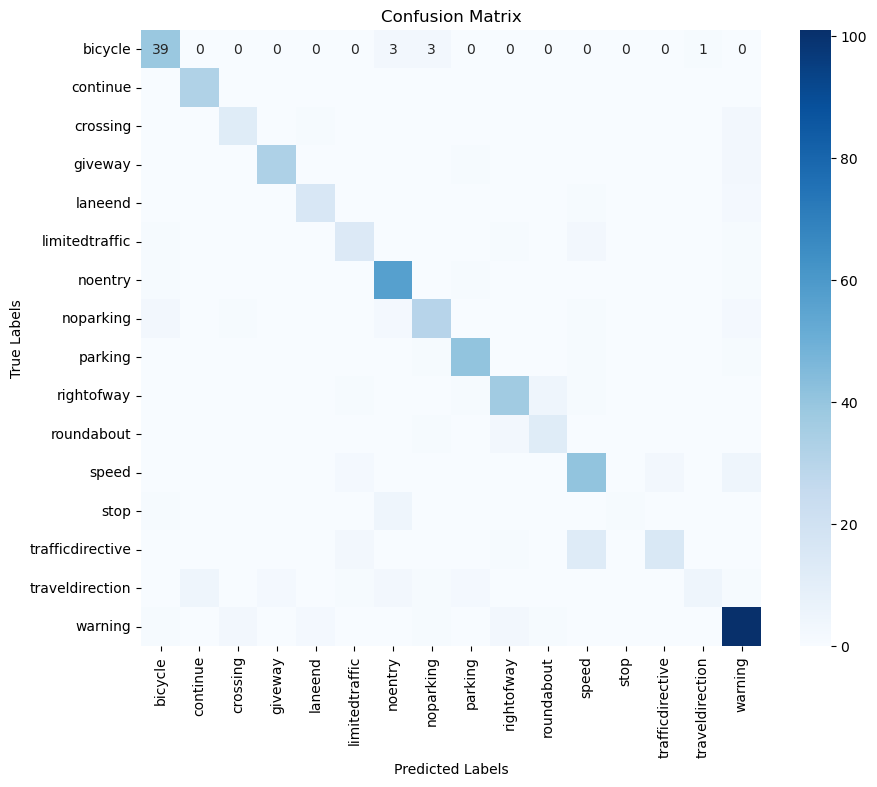

In [573]:
y_pred_val_prob = baseline_categorical.predict(val_generator)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(val_generator.classes, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(val_generator.classes, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## CNN Model for Multi Class

In [574]:
from tensorflow.keras import models, layers

num_classes = 16  # Adjust the number of classes according to your task

cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Input for grayscale images, 1 channel
    layers.Conv2D(32, (3, 3), padding='same'),  # First convolutional layer, 32 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(64, (3, 3), padding='same'),  # Second convolutional layer, 64 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Conv2D(128, (3, 3), padding='same'),  # Third convolutional layer, 128 filters
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.MaxPooling2D((2, 2)),  # Max pooling
    layers.Flatten(),  # Flatten the convolutional result
    layers.Dense(512),  # Fully connected layer
    layers.BatchNormalization(),  # Adding batch normalization
    layers.Activation('relu'),  # Activation layer
    layers.Dense(num_classes, activation='softmax')  # Output layer, using softmax activation
])

cnn_model.compile(
    loss='categorical_crossentropy',  # Using categorical crossentropy loss
    optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer
    metrics=['accuracy']  # Using accuracy as metric
)


In [575]:
epochs = 50
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.4800 - loss: 1.7626 - val_accuracy: 0.0721 - val_loss: 2.6877
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8427 - loss: 0.5265 - val_accuracy: 0.1460 - val_loss: 3.1893
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9036 - loss: 0.3421 - val_accuracy: 0.0973 - val_loss: 3.9888
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9262 - loss: 0.2435 - val_accuracy: 0.1040 - val_loss: 4.8121
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9428 - loss: 0.2008 - val_accuracy: 0.1510 - val_loss: 4.8036
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9547 - loss: 0.1758 - val_accuracy: 0.1393 - val_loss: 4.1602
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9521 - loss: 0.1615 - val_accuracy: 0.2181 - val_loss: 4.1110
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9624 - loss: 0.1248 - val_accuracy: 0.3054 -

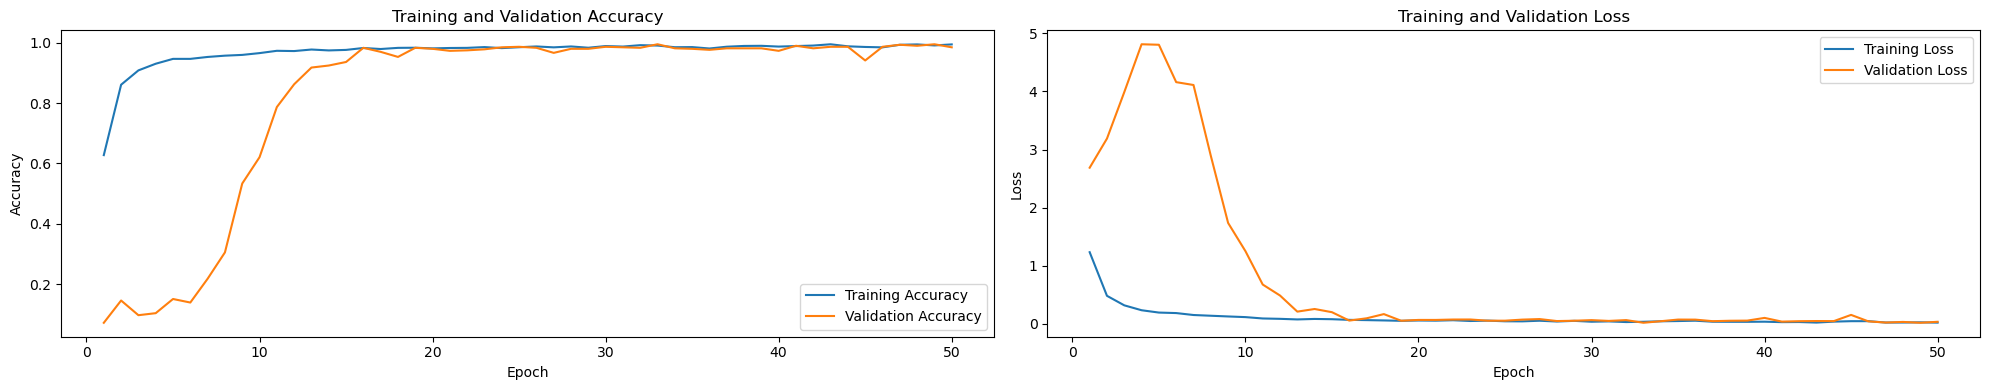

In [576]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    epochs_range = range(1, len(history.history['accuracy']) + 1)  
    metrics = [key for key in history.history.keys() if not key.startswith("val_")]  
    _, axes = plt.subplots(1, len(metrics), figsize=(20, 4))  

    for idx, metric in enumerate(metrics):
        axes[idx].plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        axes[idx].plot(epochs_range, history.history[f"val_{metric}"], label=f'Validation {metric.capitalize()}')
        axes[idx].legend()
        axes[idx].set_title(f'Training and Validation {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn)


                  precision    recall  f1-score   support

         bicycle       0.85      0.85      0.85        46
        continue       0.86      1.00      0.93        32
        crossing       0.75      0.75      0.75        16
         giveway       0.94      0.89      0.92        37
         laneend       0.84      0.84      0.84        19
  limitedtraffic       0.67      0.70      0.68        20
         noentry       0.81      0.95      0.88        60
       noparking       0.81      0.77      0.79        39
         parking       0.89      0.93      0.91        44
      rightofway       0.82      0.82      0.82        45
      roundabout       0.67      0.75      0.71        16
           speed       0.67      0.80      0.73        51
            stop       1.00      0.14      0.25         7
trafficdirective       0.83      0.47      0.60        32
 traveldirection       0.83      0.25      0.38        20
         warning       0.84      0.90      0.87       112

        accu

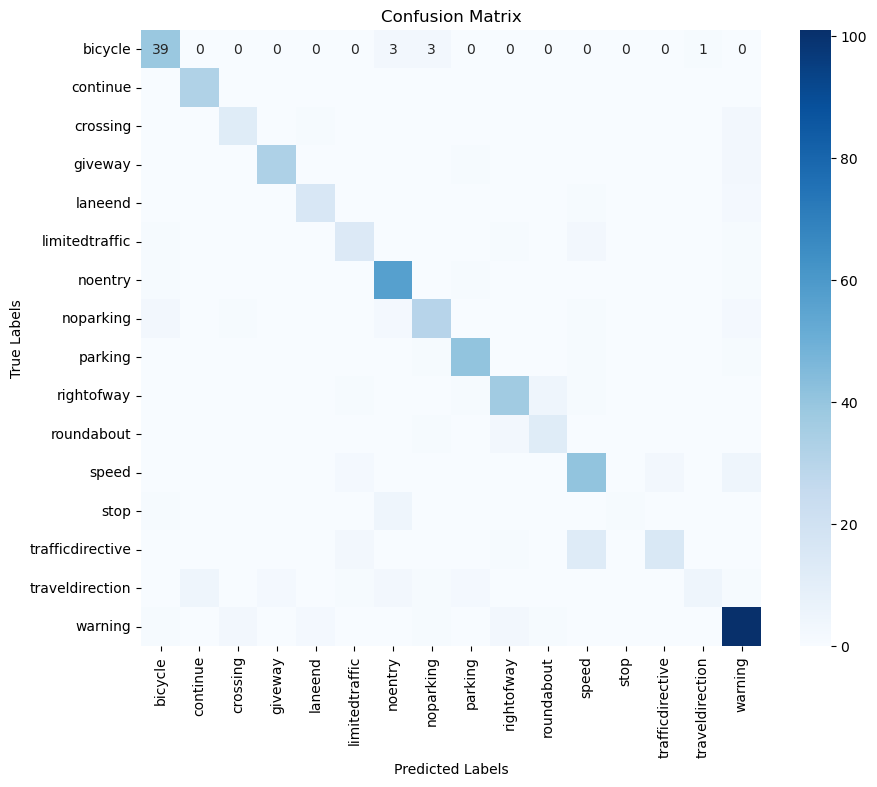

In [577]:
import numpy as np

if y_pred_val_prob.ndim > 1:
    y_pred_val = np.argmax(y_pred_val_prob, axis=1)
else:
    y_pred_val = y_pred_val_prob  

y_val = val_generator.labels

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(y_val, y_pred_val, target_names=label_names)
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
